# Transfermarkt Transfers

**Disclaimers** : 
- The analysis scope is based on the dataset, especially on the defined transfer date range. Some info and numbers may differ from the real complete data out there.
- Some data may be missing because of scraping issue or restricted by the transfermarkt themselves. These could causing an innacurate conclusions.

The dataset was politely scraped from [transfermarkt.com](https://www.transfermarkt.com/statistik/transfertage) using Scrapy and Splash. The notebook will be updated as the scraping goes from time to time. Check the `Transfer Date Range` section below to find out the oldest and latest date.

## Preparation

### Import Libraries

In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sys
import datetime
import numpy as np
from IPython.core.interactiveshell import InteractiveShell

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

print("python version: ", sys.version)
print("pandas version: ", pd.__version__)
print("seaborn version: ", sns.__version__)

print("last run: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

python version:  3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
pandas version:  1.3.4
seaborn version:  0.11.2
last run:  2022-02-09 01:02:55


### Loading Dataset

In [32]:
df = pd.read_csv("transfermarkt-transfers.csv")
dataset = df.copy()

# developer-friendly column names and format
dataset.columns = [x.lower().replace('-', '_').replace(' ', '_') for x in dataset.columns.to_list()]

### Variables and Functions

In [33]:
binary_pallete = ['#EF4444', '#10B981']
binary_order = ['No', 'Yes']

def remove_outlier_iqr(dataset, col):
    filtered_entries = np.array([True] * len(dataset))
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((dataset[col] >= low_limit) & (dataset[col] <= high_limit)) & filtered_entries

    dataset = dataset[filtered_entries]
    return dataset

## Dataset Exploration

In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90916 entries, 0 to 90915
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            89863 non-null  float64
 1   name                 90916 non-null  object 
 2   age                  90443 non-null  float64
 3   position             90916 non-null  object 
 4   national_1           76855 non-null  object 
 5   national_2           11717 non-null  object 
 6   left_club            89960 non-null  object 
 7   left_club_league     65980 non-null  object 
 8   joined_club          89300 non-null  object 
 9   joined_club_league   61639 non-null  object 
 10  transfer_date        90916 non-null  object 
 11  transfer_date_p      90916 non-null  object 
 12  market_value         90916 non-null  object 
 13  market_value_p       90916 non-null  int64  
 14  fee                  90912 non-null  object 
 15  left_club_country    83584 non-null 

- The dataset has `23 columns` and `89404 rows` (the number will keep increasing)
- The default features mostly are object or categorical, but has a few numerical features too.

In [35]:
dataset.sample(10, random_state=1)

,player_id,name,age,position,national_1,national_2,left_club,left_club_league,joined_club,joined_club_league,transfer_date,transfer_date_p,market_value,market_value_p,fee,left_club_country,joined_club_country,loan_fee,loan_fee_p,created_at,updated_at,temp_dates_page,temp_players_page
50679,191407.0,Oussama Haddadi,29.0,Left-Back,Tunisia,NaN,Al-Ettifaq,Professional League,Y. Malatyaspor,Süper Lig,"Jul 1, 2021",2021-07-01,€2.50m,2500000,€384Th.,Saudi Arabia,Turkey,NaN,NaN,2021-12-13 22:55:37,2021-12-13 22:55:37,NaN,11.0
33900,612813.0,Ali Eren Dasdemir,22.0,Right Winger,Turkey,NaN,Genclerbirligi,Süper Lig,Cankaya FK,3.Lig Grup 1,"Jan 22, 2021",2021-01-22,€25Th.,25000,loan transfer,Turkey,Turkey,NaN,NaN,2021-11-02 11:41:44,2021-11-02 11:41:44,NaN,NaN
5924,398733.0,Gennaro Sorrentino,31.0,Centre-Forward,Italy,NaN,Biancavilla,Serie D - I,Portici,Serie D - H,"Oct 3, 2020",2020-10-03,€25Th.,25000,free transfer,Italy,Italy,NaN,NaN,2021-10-04 16:11:24,2021-10-04 16:11:24,NaN,NaN
47760,44935.0,Mauricio Victorino,38.0,Centre-Back,Uruguay,Italy,Danubio FC,Liga de Ascenso,Without Club,NaN,"Apr 1, 2021",2021-04-01,€50Th.,50000,-,Uruguay,NaN,NaN,NaN,2021-11-28 19:32:05,2021-11-28 19:32:05,NaN,NaN
30312,316256.0,In-kyu Lee,28.0,Centre-Back,"Korea, South",NaN,Unknown,NaN,Dangjin Citizen,K4 League,"Jan 15, 2021",2021-01-15,€50Th.,50000,?,NaN,"Korea, South",NaN,NaN,2021-10-24 21:35:55,2021-10-24 21:35:55,NaN,NaN
35857,413595.0,Samuel Narh,26.0,Centre-Forward,Norway,NaN,Sotra SK,PostNord-ligaen Avd. 2,Länk FCV,NaN,"Jan 28, 2021",2021-01-28,€50Th.,50000,free transfer,Norway,Portugal,NaN,NaN,2021-11-02 11:54:00,2021-11-02 11:54:00,NaN,NaN
9051,128223.0,Álvaro Morata,27.0,Centre-Forward,Spain,NaN,Atlético Madrid,LaLiga,Juventus,Serie A,"Sep 22, 2020",2020-09-22,€36.00m,36000000,Loan fee:,Spain,Italy,€20.00m,20000000.0,2021-10-04 16:36:24,2021-10-04 16:36:24,NaN,NaN
56968,272549.0,Tony Mauricio,27.0,Attacking Midfield,NaN,NaN,Lens,Ligue 1,FC Sochaux,Ligue 2,"Jul 1, 2021",2021-07-01,€2.00m,2000000,?,France,France,NaN,NaN,2021-12-15 01:28:05,2021-12-15 01:28:05,NaN,262.0
8993,37012.0,Joel Grant,33.0,Right Winger,Jamaica,England,Plymouth,League One,Swindon Town,League One,"Sep 18, 2020",2020-09-18,€250Th.,250000,free transfer,England,England,NaN,NaN,2021-10-04 16:36:19,2021-10-04 16:36:19,NaN,NaN
71828,815398.0,Aleksey Mikhailov,18.0,Centre-Back,Russia,NaN,FK Sochi II,U19 M-Liga,Master-Saturn,U19 M-Liga,"Jul 21, 2021",2021-07-21,€10Th.,10000,free transfer,Russia,Russia,NaN,NaN,2021-12-15 04:09:51,2021-12-15 04:09:51,6.0,10.0


- the `player_id` feature is a numerical, but actually it's not a measureable value. We will remove it.
- the `fee` feature has invalid values like `-` and `?`. We will clean it later.
- the `fee` also has inconsistent values like `€500Th.`, `€450Th.`, `free transfer`, `loan transfer` that could be transformed into a numerical feature and one-hot encoding the categorical ones later.
- `market_value` and `transfer_date` has the parsed version of the values. So we will remove these features.
- `loan_fee` and `loan_fee_p` values are almost missing entirely. We will remove them.
- `created_at`, `updated_at`, `temp_dates_page` and `temp_players_page` are not useful for analysis and we will remove them.

In [36]:
dataset.select_dtypes(exclude='number').describe()

,name,position,national_1,national_2,left_club,left_club_league,joined_club,joined_club_league,transfer_date,transfer_date_p,market_value,fee,left_club_country,joined_club_country,loan_fee,created_at,updated_at
count,90916,90916,76855,11717,89960,65980,89300,61639,90916,90916,90916,90912,83584,79868,409,90916,90916
unique,61622,17,208,184,8738,372,9624,390,538,538,156,533,170,178,130,3676,3676
top,Dudu,Centre-Forward,Italy,Italy,Without Club,Premier League,Without Club,Premier League,"Jul 1, 2021",2021-07-01,€50Th.,free transfer,Italy,Italy,€500Th.,2021-11-02 11:39:54,2021-11-02 11:39:54
freq,20,14077,8383,1553,6808,1792,9546,1347,13172,13172,15194,45932,10437,10226,38,100,100


- the `name` almost entirely unique as categorial feature. We will remove it.

### Transfers Date Range

In [37]:
print(f"from {dataset.sort_values(['transfer_date_p']).iloc[[0, -1]].values[0, 10]} to {dataset.sort_values(['transfer_date_p']).iloc[[0, -1]].values[1, 10]}")

from Jul 4, 2020 to Dec 31, 2021


## Preprocessing

### One-Hot Encoding

To minify droping missing values or features, we could simply concatenating the corelated features like `left_club`, `left_club_leage` and `left_club_country`, as well for the `joined` ones.

In [38]:
dataset['loan_transfer'] = False
dataset['free_transfer'] = False
dataset['loan_transfer'] = dataset['fee'].apply(lambda fee: True if (fee == 'loan transfer') else False)
dataset['free_transfer'] = dataset['fee'].apply(lambda fee: True if (fee == 'free transfer') else False)

dataset.sample(5, random_state=1)

,player_id,name,age,position,national_1,national_2,left_club,left_club_league,joined_club,joined_club_league,transfer_date,transfer_date_p,market_value,market_value_p,fee,left_club_country,joined_club_country,loan_fee,loan_fee_p,created_at,updated_at,temp_dates_page,temp_players_page,loan_transfer,free_transfer
50679,191407.0,Oussama Haddadi,29.0,Left-Back,Tunisia,NaN,Al-Ettifaq,Professional League,Y. Malatyaspor,Süper Lig,"Jul 1, 2021",2021-07-01,€2.50m,2500000,€384Th.,Saudi Arabia,Turkey,NaN,NaN,2021-12-13 22:55:37,2021-12-13 22:55:37,NaN,11.0,False,False
33900,612813.0,Ali Eren Dasdemir,22.0,Right Winger,Turkey,NaN,Genclerbirligi,Süper Lig,Cankaya FK,3.Lig Grup 1,"Jan 22, 2021",2021-01-22,€25Th.,25000,loan transfer,Turkey,Turkey,NaN,NaN,2021-11-02 11:41:44,2021-11-02 11:41:44,NaN,NaN,True,False
5924,398733.0,Gennaro Sorrentino,31.0,Centre-Forward,Italy,NaN,Biancavilla,Serie D - I,Portici,Serie D - H,"Oct 3, 2020",2020-10-03,€25Th.,25000,free transfer,Italy,Italy,NaN,NaN,2021-10-04 16:11:24,2021-10-04 16:11:24,NaN,NaN,False,True
47760,44935.0,Mauricio Victorino,38.0,Centre-Back,Uruguay,Italy,Danubio FC,Liga de Ascenso,Without Club,NaN,"Apr 1, 2021",2021-04-01,€50Th.,50000,-,Uruguay,NaN,NaN,NaN,2021-11-28 19:32:05,2021-11-28 19:32:05,NaN,NaN,False,False
30312,316256.0,In-kyu Lee,28.0,Centre-Back,"Korea, South",NaN,Unknown,NaN,Dangjin Citizen,K4 League,"Jan 15, 2021",2021-01-15,€50Th.,50000,?,NaN,"Korea, South",NaN,NaN,2021-10-24 21:35:55,2021-10-24 21:35:55,NaN,NaN,False,False


### Handle Invalid Values

In [39]:
dataset['fee'] = dataset['fee'].apply(lambda fee: fee if (fee != '-' and fee != '?') else None)

### Find and Handle Missing Values

In [40]:
idf = dataset.isna().sum().reset_index().rename({'index': 'column', 0: 'missing'}, axis=1)
idf['percentage'] = round(idf['missing'] / dataset.shape[0], 2)
idf

,column,missing,percentage
0,player_id,1053,0.01
1,name,0,0.00
2,age,473,0.01
3,position,0,0.00
4,national_1,14061,0.15
5,national_2,79199,0.87
6,left_club,956,0.01
7,left_club_league,24936,0.27
8,joined_club,1616,0.02
9,joined_club_league,29277,0.32


- `player_id` is a unique value, we don't need to fill the blank and remove the feature later.
- `age` has a little amount of missing data. We could fill them with median value.
- `joined_club` and `left_club` has pieces of missing data. We could drop the value.
- `national_2`, `left_club_league`, `joined_club_league`, `loan_fee`, `loan_fee_p` has large amount of missing data. We could remove these features later.

In [41]:
dataset['age'].fillna(dataset['age'].median(), inplace=True)

### Remove Unnecessary Features

In [42]:
features_tobe_removed = [
    'player_id',
    'name',
    'market_value',
    'transfer_date',
    'created_at',
    'updated_at',
    'national_2',
    'loan_fee',
    'loan_fee_p',
    'temp_dates_page',
    'temp_players_page'
]

dataset.drop(features_tobe_removed, axis=1, inplace=True)

### Duplication Removal

In [43]:
print("before removal:", dataset.shape[0])

print("duplicated count:", dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)

print("after removal:", dataset.shape[0])

before removal: 90916
duplicated count: 1088
after removal: 89828


### Outlier Removal

In [44]:
current = int(dataset.shape[0])
print("before removal:", current, '\n')

number_cols = dataset.select_dtypes(include='number').columns.tolist()

total_reducted = 0
for col in number_cols:
    dataset = remove_outlier_iqr(dataset, col)
    reducted = current - int(dataset.shape[0])
    print(f"- {col}:", reducted)
    total_reducted = total_reducted + reducted
    current = current - reducted

print(f"total: {total_reducted}")
print("\nafter removal:", current)

before removal: 89828 

- age: 36
- market_value_p: 7507
total: 7543

after removal: 82285


### Casting Dtypes

In [45]:
dataset = dataset.astype({
    "age": int,
    "market_value_p": int
})

dataset['transfer_date'] = pd.to_datetime(dataset['transfer_date_p'], format='%Y-%m-%d')
dataset.drop('transfer_date_p', axis=1, inplace=True)

### Preprocessing Result

In [46]:
dataset.sample(10, random_state=1)

,age,position,national_1,left_club,left_club_league,joined_club,joined_club_league,market_value_p,fee,left_club_country,joined_club_country,loan_transfer,free_transfer,transfer_date
84397,20,Left-Back,Greece,MFK Karvina,Fortuna Liga,Pohronie,Fortuna Liga,150000,loan transfer,Czech Republic,Slovakia,True,False,2021-09-06
48240,28,Attacking Midfield,China,MZ Qiuxiang,NaN,GD Red Treasure,NaN,50000,free transfer,China,China,False,True,2021-04-25
3031,22,Right-Back,Egypt,Ismaily,Premier League,Zed FC,NaN,100000,free transfer,Egypt,Egypt,False,True,2020-11-01
53410,28,Central Midfield,NaN,Honduras Progr.,Liga Nacional Apertura,Once Deportivo,Primera División Apertura,100000,free transfer,Honduras,El Salvador,False,True,2021-07-01
86056,26,Goalkeeper,Venezuela,Deportivo Pasto,Liga DIMAYOR II,AD San Carlos,Primera Div. Clausura,450000,None,Colombia,Costa Rica,False,False,2021-09-01
67454,24,Centre-Back,France,Rodez AF,Ligue 2,Concarneau,Championnat National,350000,loan transfer,France,France,True,False,2021-07-16
18487,26,Right Winger,Uzbekistan,Pakhtakor,Superliga,AGMK Olmaliq,Superliga,400000,loan transfer,Uzbekistan,Uzbekistan,True,False,2020-08-31
33324,23,Right Winger,Morocco,Nahdat Zemamra,Botola Pro Inwi,Pergolettese,Serie C - A,100000,free transfer,Morocco,Italy,False,True,2021-01-22
12875,27,Goalkeeper,Qatar,Umm Salal SC,Stars League,Muaither SC,NaN,25000,free transfer,Qatar,Qatar,False,True,2020-09-01
50814,33,Central Midfield,Wales,Rotherham,League One,Crewe Alexandra,League One,200000,free transfer,England,England,False,True,2021-07-01


In [47]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82285 entries, 1 to 90915
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   age                  82285 non-null  int32         
 1   position             82285 non-null  object        
 2   national_1           69242 non-null  object        
 3   left_club            81556 non-null  object        
 4   left_club_league     58222 non-null  object        
 5   joined_club          80954 non-null  object        
 6   joined_club_league   53959 non-null  object        
 7   market_value_p       82285 non-null  int32         
 8   fee                  54338 non-null  object        
 9   left_club_country    75359 non-null  object        
 10  joined_club_country  71787 non-null  object        
 11  loan_transfer        82285 non-null  bool          
 12  free_transfer        82285 non-null  bool          
 13  transfer_date        82285 non-

## Exploratory Data Analysis

### Descriptive Statistics

#### Numerical

In [48]:
dataset.select_dtypes(include='number').describe()

,age,market_value_p
count,82285.000000,82285.000000
mean,25.213769,133760.843410
std,4.745601,117920.246623
min,15.000000,10000.000000
25%,21.000000,50000.000000
50%,25.000000,100000.000000
75%,29.000000,200000.000000
max,41.000000,550000.000000


#### Categorical

In [49]:
dataset.select_dtypes(exclude='number').describe()

,position,national_1,left_club,left_club_league,joined_club,joined_club_league,fee,left_club_country,joined_club_country,loan_transfer,free_transfer,transfer_date
count,82285,69242,81556,58222,80954,53959,54338,75359,71787,82285,82285,82285
unique,17,208,8704,372,9590,388,248,170,178,2,2,538
top,Centre-Back,Italy,Without Club,Premier League,Without Club,Liga 2,free transfer,Italy,Italy,False,True,2021-07-01 00:00:00
freq,12758,7960,6419,1323,9058,1103,43121,9635,9398,72202,43121,12118
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-04 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31 00:00:00


### Univariate Analysis

#### Distribution Plot of Numerical Features

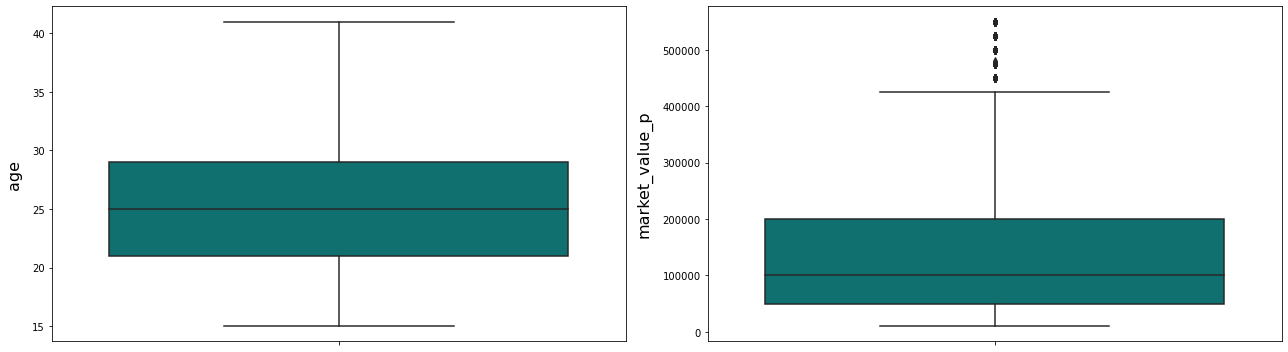

In [50]:
idf = dataset.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.boxplot(y=dataset[cols[index]], color='teal', orient='v')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();


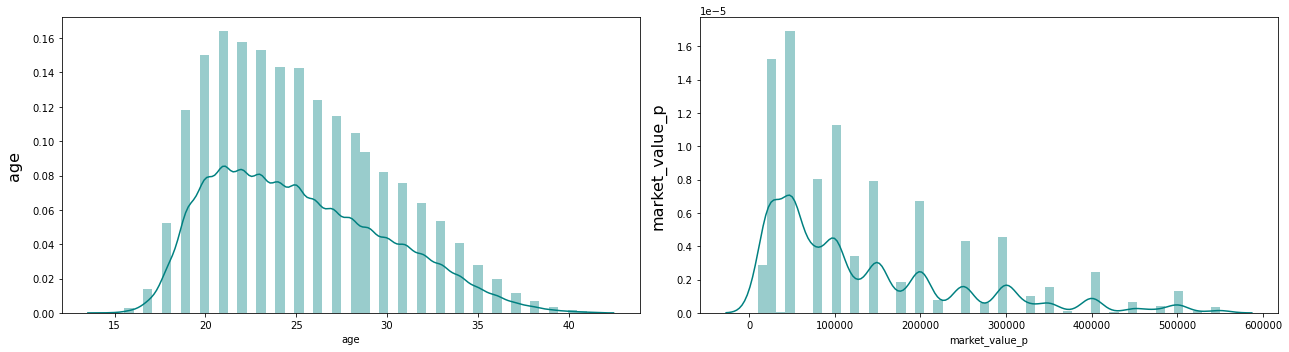

In [51]:
idf = dataset.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.distplot(dataset[cols[index]], color='teal')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

#### Count Plot For Categorical Features

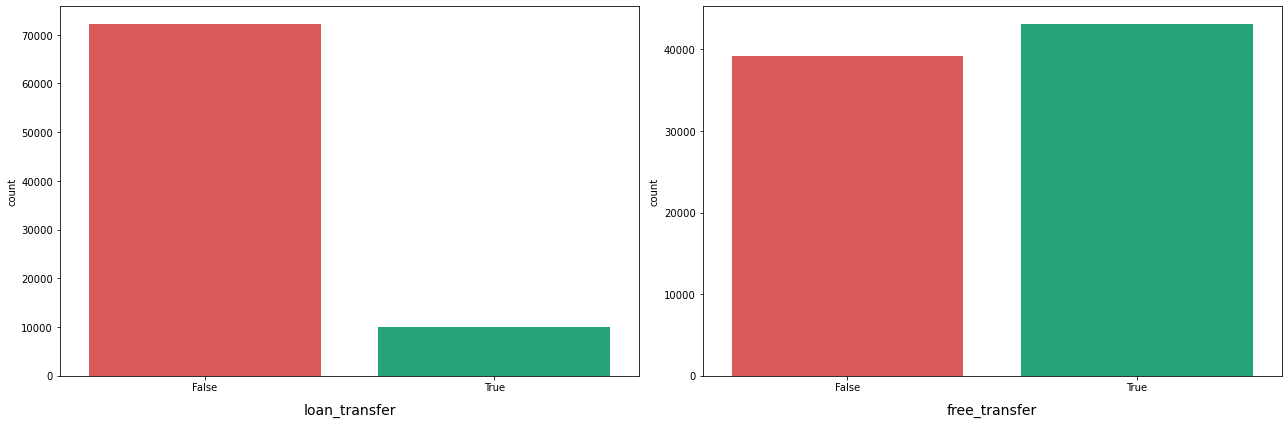

In [52]:
idf = dataset.select_dtypes(include='bool')
cols = idf.columns.tolist()

plt.figure(figsize=(18, 6))
for index in range(0, len(cols)):
    plt.subplot(1, 2, index+1)
    sns.countplot(idf[cols[index]], color='teal', orient='v', palette=binary_pallete)
    plt.tight_layout()
    plt.xlabel(cols[index], fontsize='14', labelpad=10)

plt.show();

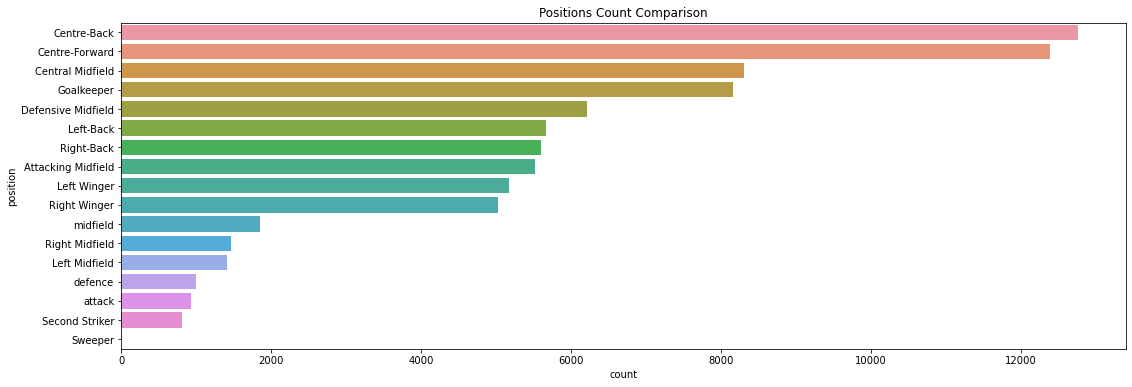

In [53]:
idf = dataset.groupby(['position'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(y='position', x='count', data=idf)
plt.title('Positions Count Comparison')
plt.show();

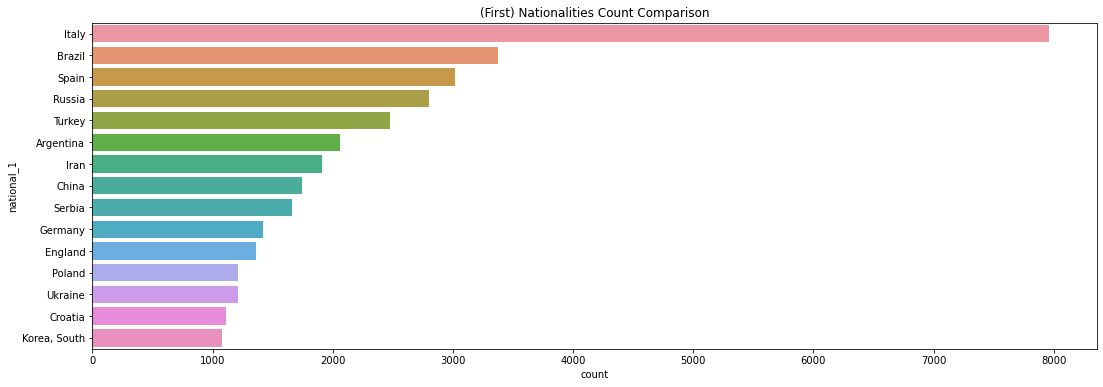

In [54]:
idf = dataset.groupby(['national_1'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(y='national_1', x='count', data=idf[:15])
plt.title('(First) Nationalities Count Comparison')
plt.show();

### Multivariate Analysis

#### Correlation Heatmap

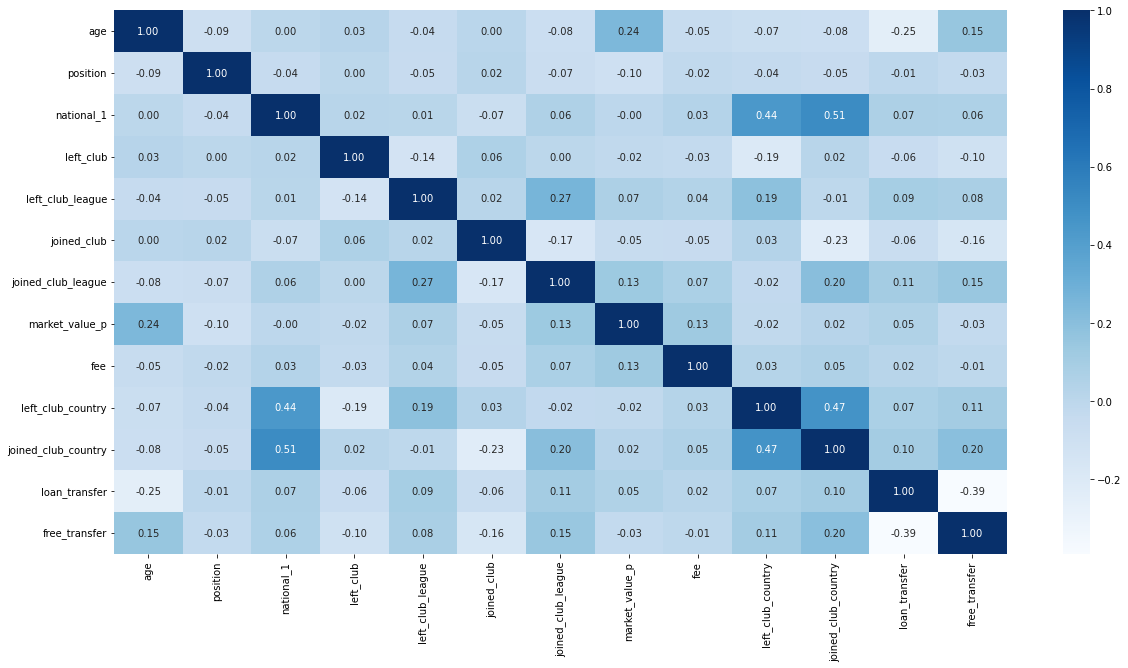

In [55]:
# label encoding for heatmap
idf = dataset.copy()
for feature in idf.select_dtypes(include='object').columns.tolist():
    idf[feature] = idf[feature].astype('category').cat.codes

plt.figure(figsize=(20, 10))
sns.heatmap(idf.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show();

#### Pairplot

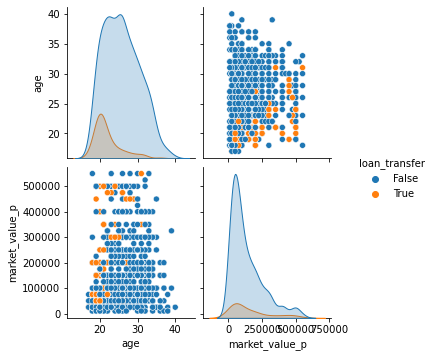

In [56]:
idf = dataset.select_dtypes(include='number')

cdf = idf.copy()
cdf['loan_transfer'] = dataset['loan_transfer']
sns.pairplot(data=cdf.sample(1000, random_state=1), hue='loan_transfer')

- loan transfer rarely happens on age above 30

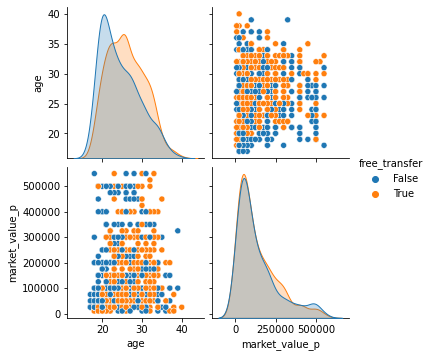

In [57]:
cdf = idf.copy()
cdf['free_transfer'] = dataset['free_transfer']
sns.pairplot(data=cdf.sample(1000, random_state=1), hue='free_transfer')

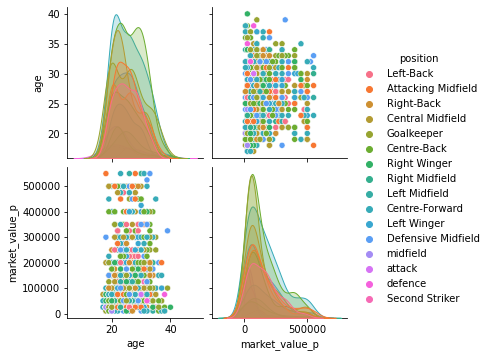

In [58]:
cdf = idf.copy()
cdf['position'] = dataset['position']
sns.pairplot(data=cdf.sample(1000, random_state=1), hue='position')

### Time Series Analysis

In [59]:
tdf = dataset.groupby(['transfer_date']).agg(
    transfer_count=pd.NamedAgg(column="age", aggfunc="count")
).reset_index().sort_values(['transfer_date'])

tdf['year'] = tdf['transfer_date'].apply(lambda transfer_date: transfer_date.year)
tdf['month'] = tdf['transfer_date'].apply(lambda transfer_date: transfer_date.month)
tdf['dayofyear'] = tdf['transfer_date'].dt.dayofyear

tdf.sample(5, random_state=1).sort_values('transfer_date')

,transfer_date,transfer_count,year,month,dayofyear
159,2020-12-10,28,2020,12,345
237,2021-02-26,190,2021,2,57
323,2021-05-30,7,2021,5,150
397,2021-08-12,314,2021,8,224
400,2021-08-15,67,2021,8,227


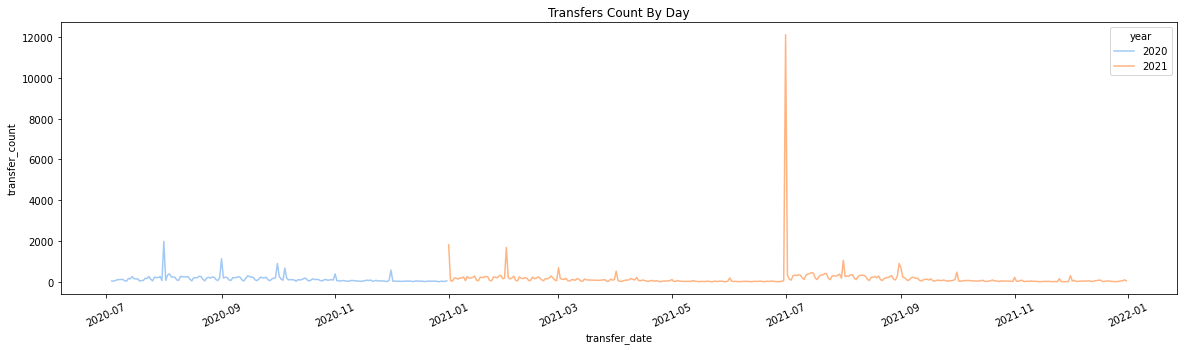

In [60]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='transfer_date', y='transfer_count', data=tdf, hue='year', palette='pastel')
plt.xticks(rotation = 25)
plt.title('Transfers Count By Day')
plt.show();

There are big amount of transfers in every first day of months

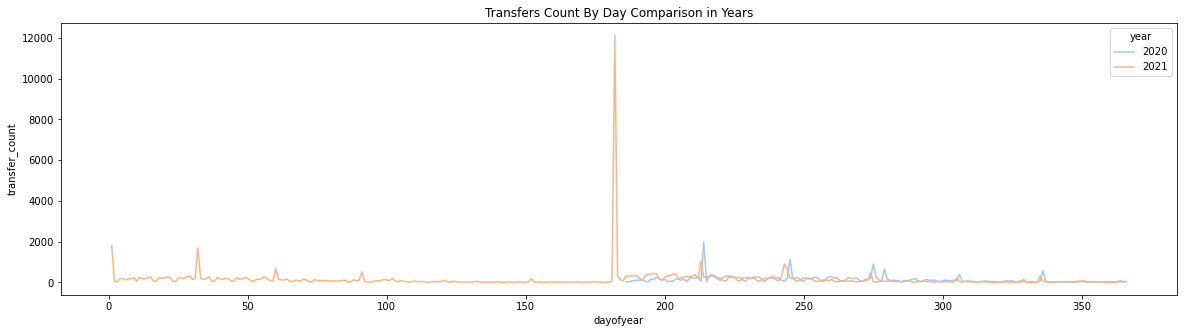

In [61]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='dayofyear', y='transfer_count', data=tdf, hue='year', palette='pastel')
plt.title('Transfers Count By Day Comparison in Years')
plt.show();

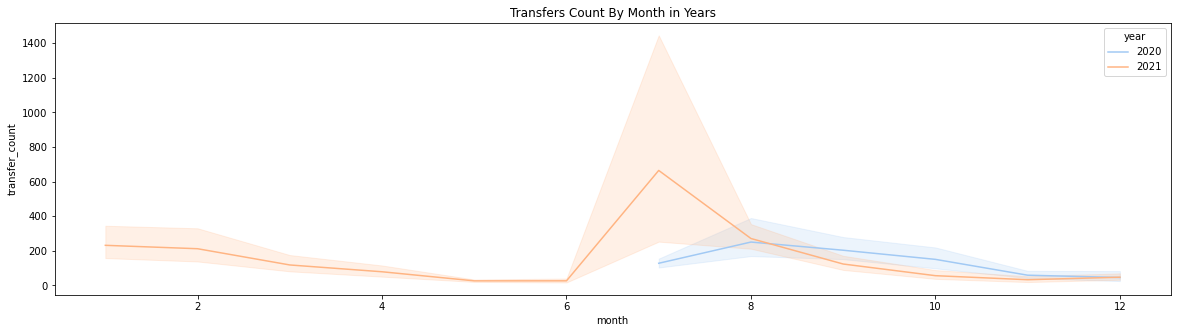

In [62]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='month', y='transfer_count', data=tdf, hue='year', palette='pastel')
plt.title('Transfers Count By Month in Years')
plt.show();

### Insights

In [63]:
pass

## Top UEFA Leagues Analysis

Transfermarkt records all foootball player transfers data around the world and the above analysis also analyzed from data over the world. Mostly people around the world observe and watch football match from the top country leagues, such as Premier league (England), Seria A (Italy) and La Liga (Spain), and so on. So why don't we narrow the data and analyze for top 7 [UEFA country](https://www.uefa.com/nationalassociations/uefarankings/country) and their division one league only?

In [64]:
uefa = dataset.copy()

# top 10 UEFA coefficient rank countries (2021/22)
top_countries = ['England', 'Italy', 'Spain', 'Germany', 'France', 'Portugal', 'Netherlands']
top_leagues = ['Premier League', 'Serie A', 'LaLiga', 'Bundesliga', 'Ligue 1', 'Liga Bwin', 'Eredivisie']

# filter only for transfer-in by top countries and top leagues
uefa = uefa[uefa['joined_club_country'].isin(top_countries)]
uefa = uefa[uefa['joined_club_league'].isin(top_leagues)]

# handle null value of left_club and joined_club
uefa.dropna(subset=['age', 'left_club', 'joined_club'], inplace=True)
uefa['national_1'].fillna('No Nationality', inplace=True)

# feature selection
uefa = uefa[[
    'age',
    'position',
    'national_1',
    'left_club',
    'left_club_league',
    'left_club_country',
    'joined_club',
    'joined_club_league',
    'joined_club_country',
    'free_transfer',
    'loan_transfer',
    'market_value_p',
    'transfer_date',
]]

# renaming columns
uefa.rename({'market_value_p': 'market_value'}, axis=1, inplace=1)

# casting data types
uefa = uefa.astype({
    "age": int,
    "market_value": int
})

uefa.sample(5, random_state=1)

,age,position,national_1,left_club,left_club_league,left_club_country,joined_club,joined_club_league,joined_club_country,free_transfer,loan_transfer,market_value,transfer_date
81397,27,Centre-Back,No Nationality,CD Lugo,LaLiga2,Spain,Boavista,Liga Bwin,Portugal,True,False,500000,2021-08-31
64129,21,Defensive Midfield,Burkina Faso,KV Mechelen,Jupiler Pro League,Belgium,Belenenses SAD,Liga Bwin,Portugal,True,False,50000,2021-07-04
18708,23,Goalkeeper,Brazil,AS Roma,Serie A,Italy,Gil Vicente,Liga Bwin,Portugal,False,True,400000,2020-08-19
67105,26,Goalkeeper,Italy,Brescia,Serie B,Italy,Genoa,Serie A,Italy,True,False,150000,2021-07-12
6326,20,Left Winger,Italy,Pro Vercelli,Serie C - A,Italy,Crotone,Serie A,Italy,False,False,50000,2020-10-04


In [65]:
uefa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 202 to 89542
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   age                  622 non-null    int32         
 1   position             622 non-null    object        
 2   national_1           622 non-null    object        
 3   left_club            622 non-null    object        
 4   left_club_league     531 non-null    object        
 5   left_club_country    593 non-null    object        
 6   joined_club          622 non-null    object        
 7   joined_club_league   622 non-null    object        
 8   joined_club_country  622 non-null    object        
 9   free_transfer        622 non-null    bool          
 10  loan_transfer        622 non-null    bool          
 11  market_value         622 non-null    int32         
 12  transfer_date        622 non-null    datetime64[ns]
dtypes: bool(2), datetime64[ns](1), 

### Exploratory Data Analysis

#### Univariate Analysis

##### Distribution Plot for Numerical Features

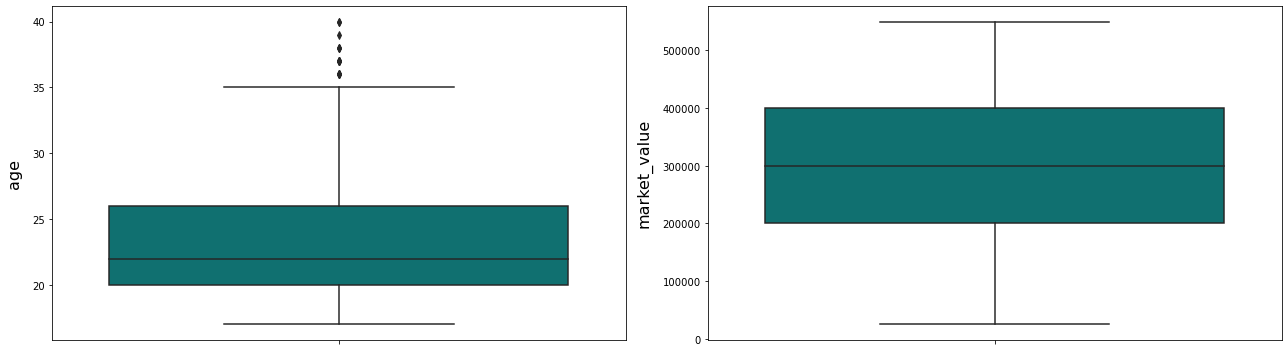

In [66]:
idf = uefa.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.boxplot(y=uefa[cols[index]], color='teal', orient='v')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

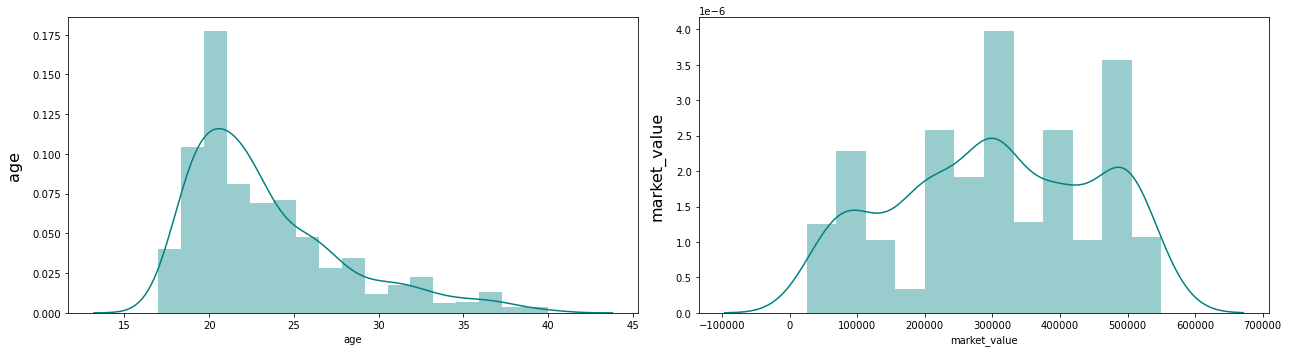

In [67]:
idf = uefa.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.distplot(uefa[cols[index]], color='teal')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

##### Count Plot For Categorical Features

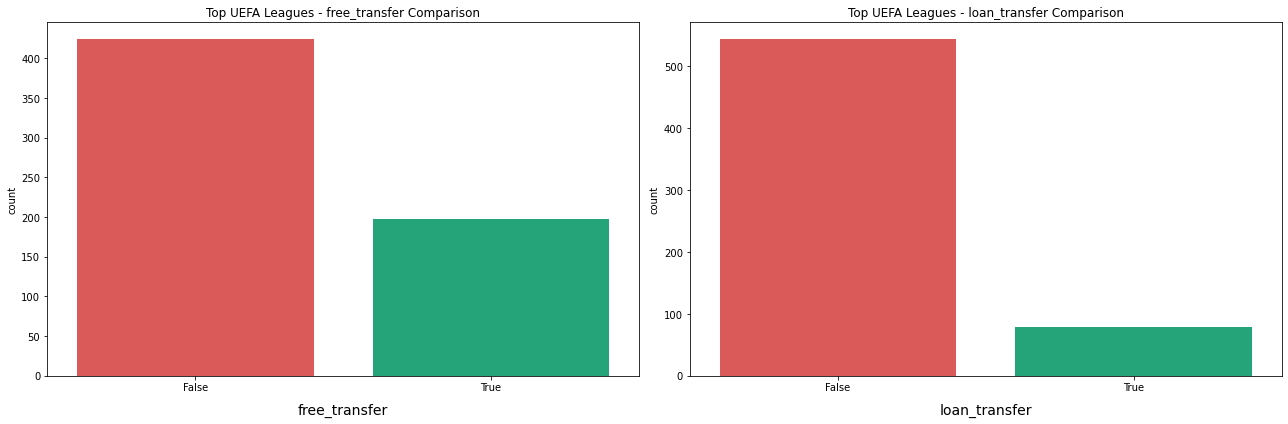

In [68]:
idf = uefa.select_dtypes(include='bool')
cols = idf.columns.tolist()

plt.figure(figsize=(18, 6))
for index in range(0, len(cols)):
    plt.subplot(1, 2, index+1)
    sns.countplot(idf[cols[index]], color='teal', orient='v', palette=binary_pallete)
    plt.tight_layout()
    plt.xlabel(cols[index], fontsize='14', labelpad=10)
    plt.title(f'Top UEFA Leagues - {cols[index]} Comparison')

plt.show();

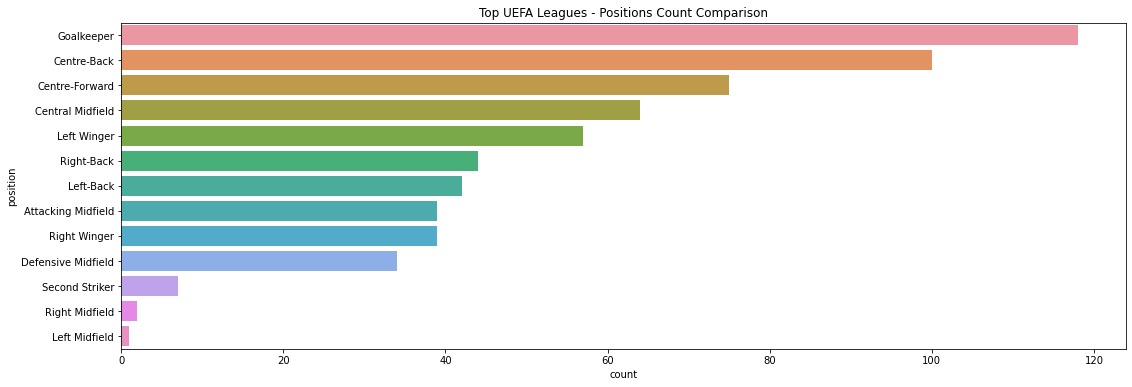

In [69]:
idf = uefa.groupby(['position'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(y='position', x='count', data=idf)
plt.title('Top UEFA Leagues - Positions Count Comparison')
plt.show();

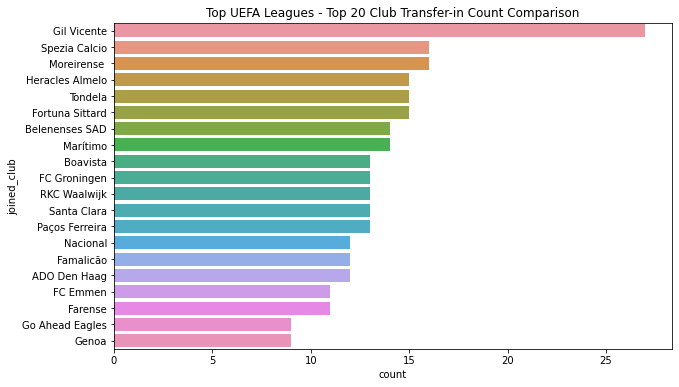

In [70]:
idf = uefa.groupby(['joined_club'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

top = 20
plt.figure(figsize=(10,6))
sns.barplot(y='joined_club', x='count', data=idf.head(top))
plt.title(f'Top UEFA Leagues - Top {top} Club Transfer-in Count Comparison')
plt.show();

#### Multivariate Analysis

##### Correlation Heatmap

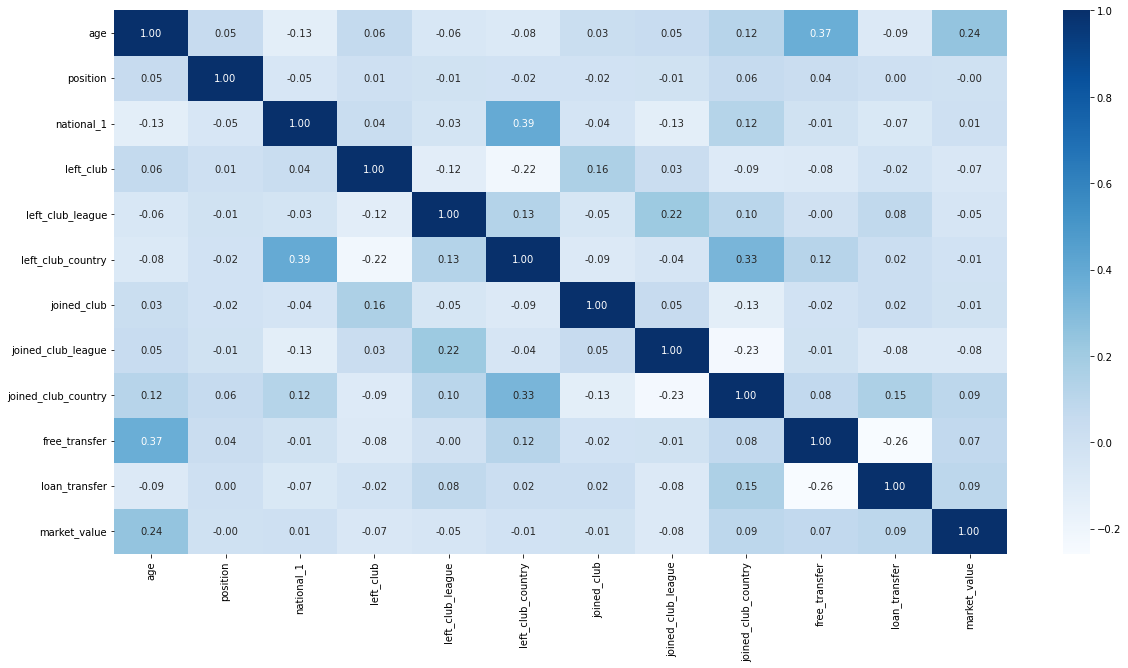

In [71]:
# label encoding for heatmap
idf = uefa.copy()
for feature in idf.select_dtypes(include='object').columns.tolist():
    idf[feature] = idf[feature].astype('category').cat.codes

plt.figure(figsize=(20, 10))
sns.heatmap(idf.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show();

##### Pairplot

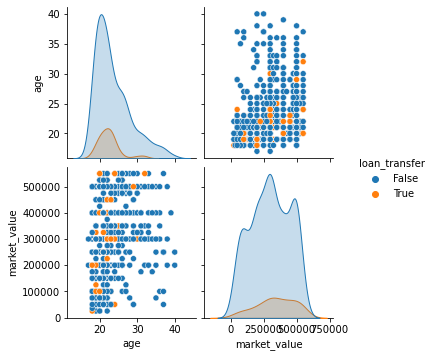

In [72]:
idf = uefa.select_dtypes(include='number')

cdf = idf.copy()
cdf['loan_transfer'] = uefa['loan_transfer']
sns.pairplot(data=cdf, hue='loan_transfer')
plt.show();

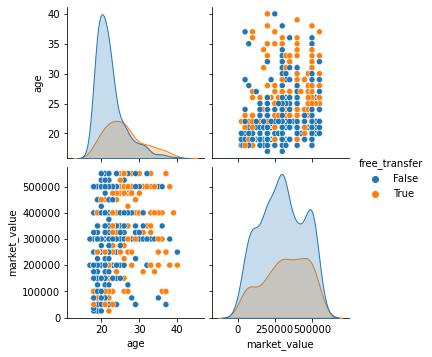

In [73]:
cdf = idf.copy()
cdf['free_transfer'] = dataset['free_transfer']
sns.pairplot(data=cdf, hue='free_transfer')
plt.show();

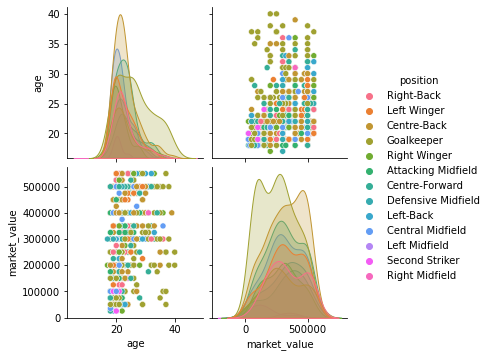

In [74]:
cdf = idf.copy()
cdf['position'] = uefa['position']
sns.pairplot(data=cdf, hue='position')
plt.show();

### Time Series Analysis

In [75]:
tdf = uefa.groupby(['transfer_date']).agg(
    transfer_count=pd.NamedAgg(column="age", aggfunc="count")
).reset_index().sort_values(['transfer_date'])

tdf['year'] = tdf['transfer_date'].apply(lambda transfer_date: transfer_date.year)
tdf['month'] = tdf['transfer_date'].apply(lambda transfer_date: transfer_date.month)
tdf['dayofyear'] = tdf['transfer_date'].dt.dayofyear

tdf.sample(5, random_state=1).sort_values('transfer_date')

,transfer_date,transfer_count,year,month,dayofyear
19,2020-08-08,2,2020,8,221
35,2020-08-26,3,2020,8,239
48,2020-09-10,3,2020,9,254
91,2021-01-11,1,2021,1,11
164,2021-10-01,2,2021,10,274


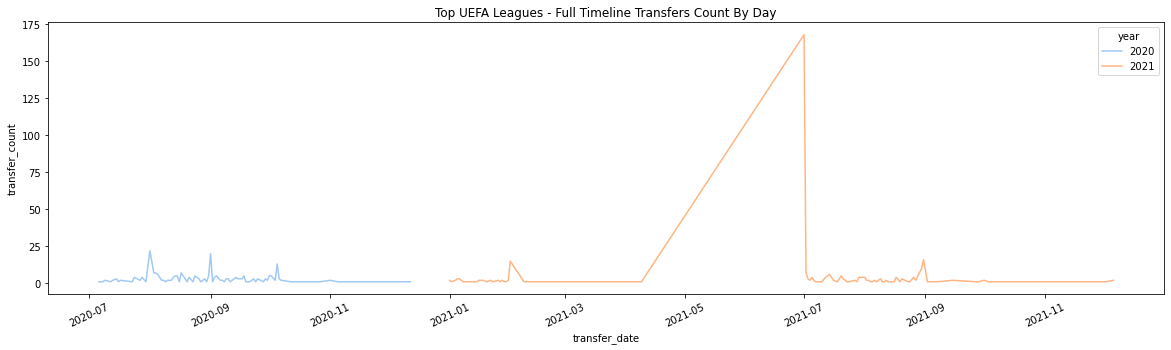

In [76]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='transfer_date', y='transfer_count', data=tdf, hue='year', palette='pastel')
plt.xticks(rotation = 25)
plt.title('Top UEFA Leagues - Full Timeline Transfers Count By Day')
plt.show();

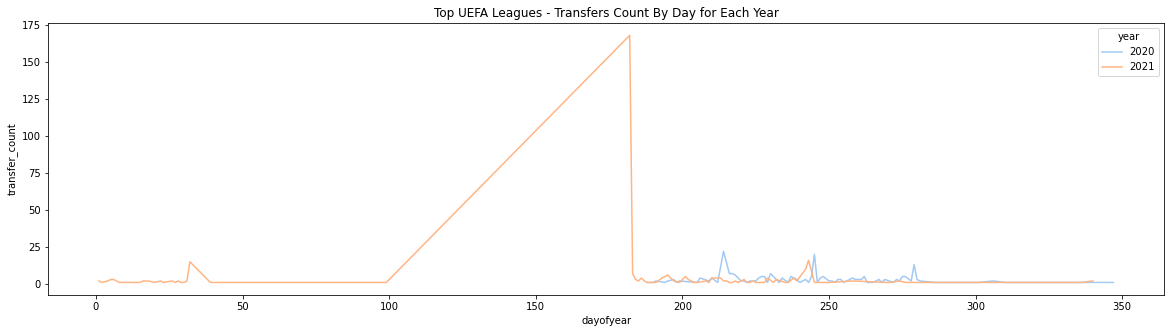

In [77]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='dayofyear', y='transfer_count', data=tdf, hue='year', palette='pastel')
plt.title('Top UEFA Leagues - Transfers Count By Day for Each Year')
plt.show();